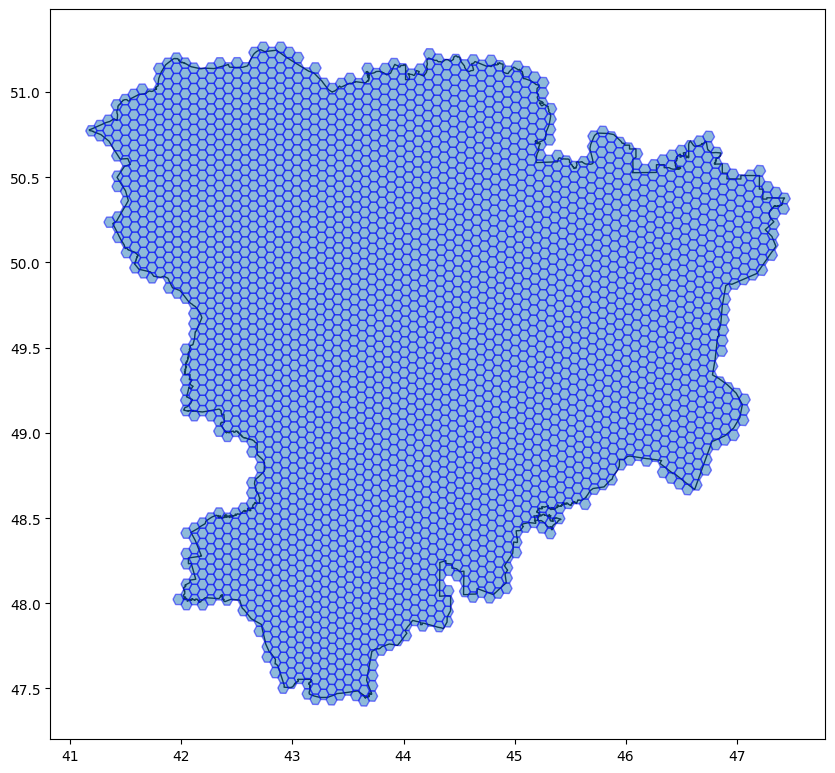

In [31]:
import osmnx as ox
import geopandas as gpd
import h3
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# 1. Загружаем границы Волгоградской области
place_name = "Volgograd Oblast, Russia"
area = ox.geocode_to_gdf(place_name)

# Преобразуем границы в гео-координаты
geometry = area['geometry'].iloc[0]  # Извлекаем геометрию области

# 2. Определяем разрешение для гексагональной сетки
resolution = 6

# 3. Определяем bounding box для области
minx, miny, maxx, maxy = geometry.bounds

# 4. Проходим по всей территории внутри bounding box и создаем гексагоны
hexagons = set()
step_size = 0.01  # Шаг сетки (чем меньше, тем больше гексагонов)
lat_range = np.arange(miny, maxy, step_size)
lon_range = np.arange(minx, maxx, step_size)

for lat in lat_range:
    for lon in lon_range:
        hex_id = h3.geo_to_h3(lat, lon, resolution)
        hexagons.add(hex_id)

# 5. Преобразуем H3 гексагоны обратно в полигоны и фильтруем их по границам Волгоградской области
def h3_to_polygon(h):
    boundary = h3.h3_to_geo_boundary(h, geo_json=True)
    return Polygon(boundary)

# Преобразуем гексагоны в полигоны
hex_polygons = [h3_to_polygon(h) for h in hexagons]
gdf_hex = gpd.GeoDataFrame({'geometry': hex_polygons}, crs="EPSG:4326")

# Оставляем только те гексагоны, которые пересекаются с границами области
gdf_hex = gdf_hex[gdf_hex.intersects(geometry)]

# 6. Визуализация гексагональной сетки и границ Волгоградской области
fig, ax = plt.subplots(figsize=(10, 10))
area.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
gdf_hex.plot(ax=ax, edgecolor="blue", alpha=0.5)

plt.show()

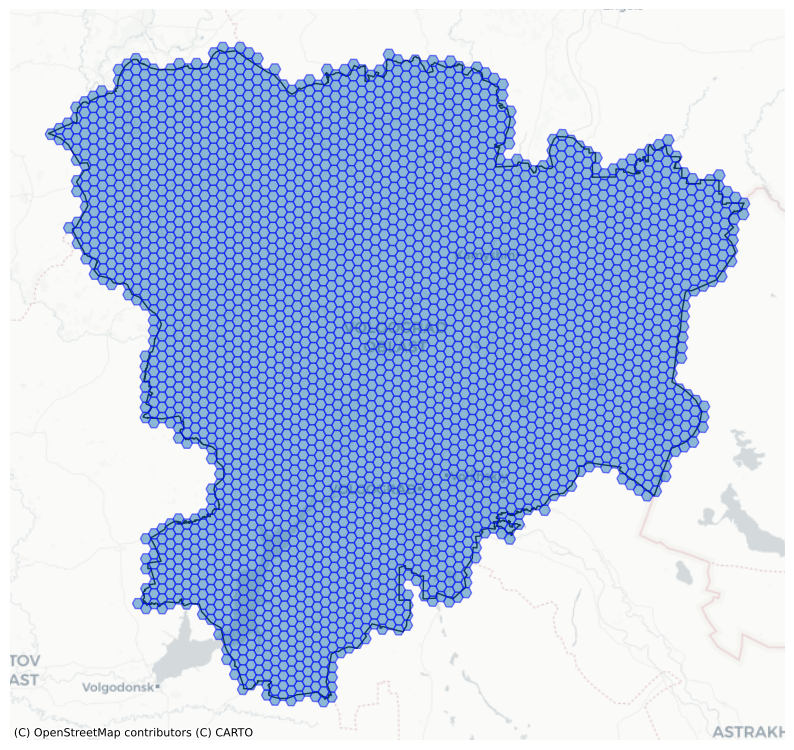

In [47]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))

# Отрисовываем границы области
area.to_crs(epsg=3857).plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Отрисовываем гексагональную сетку
gdf_hex.to_crs(epsg=3857).plot(ax=ax, edgecolor="blue", alpha=0.5)

# Добавляем подложку "positron"
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Убираем оси
ax.set_axis_off()

# Отображаем карту
plt.show()

In [44]:
gdf_hex = gdf_hex.reset_index(drop=True)
gdf_hex['id'] = gdf_hex.index
gdf_hex

,geometry,id
0,"POLYGON ((45.98550 48.84286, 46.00861 48.81152...",0
1,"POLYGON ((43.27000 49.33269, 43.29455 49.30226...",1
2,"POLYGON ((42.65521 48.07623, 42.67940 48.04591...",2
3,"POLYGON ((41.91202 49.93964, 41.93745 49.90974...",3
4,"POLYGON ((46.52436 50.62385, 46.54806 50.59251...",4
...,...,...
3229,"POLYGON ((44.08600 50.83199, 44.11095 50.80145...",3229
3230,"POLYGON ((42.73882 49.06699, 42.76346 49.03672...",3230
3231,"POLYGON ((46.11714 49.53941, 46.14052 49.50809...",3231
3232,"POLYGON ((42.06302 50.11986, 42.08848 50.08992...",3232


In [46]:
territiry = gdf_hex[gdf_hex['id'] == 6] # указать id выбранной вами территории
territiry

,geometry,id
6,"POLYGON ((44.31495 50.67770, 44.33973 50.64707...",6


In [45]:
# gdf_hex.to_file('gdf_hex.geojson', driver='GeoJSON') 